Week 1

In [ ]:
# =============================
# Standard Libraries
# =============================
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations
from joblib import parallel_backend
from tqdm.auto import tqdm
import kagglehub
from IPython.display import display


# =============================
# Data Science Libraries
# =============================
import numpy as np
import pandas as pd
import optuna

# =============================
# Visualization
# =============================
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker
import seaborn as sns

# =============================
# Scikit-learn
# =============================
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold,
    ParameterGrid,
)
import sklearn.model_selection._search as sk_search
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeClassifier, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import sklearn.model_selection._validation as sk_validation

# =============================
# Global
# =============================
random_state = 42
N_ROWS = 5_000_000  # sample size for all datasets
pd.set_option("display.float_format", lambda x: f"{x:.6f}")

# =============================
# Utils
# =============================
def dollar_format(x, pos=None):
    return f"${x:,.0f}"

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def try_read_csv(folder, fname, **kwargs):
    fp = os.path.join(folder, fname)
    return pd.read_csv(fp, **kwargs) if os.path.exists(fp) else None

def list_csvs(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(".csv")]

def simple_random_sample(steam, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    n = len(steam)
    if (n_rows is None) == (frac is None):
        raise ValueError("pass exactly one of n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        k = int(np.floor(frac * n))
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        k = min(int(n_rows), n)
    if k >= n:
        return steam.copy()
    t0 = time.perf_counter()
    rng = np.random.default_rng(random_state)
    idx = rng.choice(n, size=k, replace=False)
    out = steam.iloc[idx].copy()
    t1 = time.perf_counter()
    print({"rows": n, "picked": int(len(out)), "frac": float(len(out) / n), "elapsed_sec": round(t1 - t0, 3)})
    return out

def stratified_sample(steam, y, n_rows=None, frac=None, random_state=42):
    if steam is None:
        raise ValueError("steam is None")
    y_arr = steam[y].to_numpy() if isinstance(y, str) else np.asarray(y)
    n = len(steam)
    if len(y_arr) != n:
        raise ValueError("X and y length mismatch")
    if n_rows is not None and frac is not None:
        frac = None
    if n_rows is None and frac is None:
        raise ValueError("provide n_rows or frac")
    if frac is not None:
        if not (0 < frac <= 1):
            raise ValueError("frac must be in (0, 1]")
        test_size = float(frac)
        use_frac, use_n = frac, None
    else:
        if int(n_rows) <= 0:
            raise ValueError("n_rows must be > 0")
        test_size = min(float(n_rows) / n, 1.0)
        use_frac, use_n = None, int(n_rows)
    if test_size >= 1.0:
        return steam.copy()
    _, counts = np.unique(y_arr, return_counts=True)
    if np.any(counts < 2):
        print("Warning: some classes <2 samples; using simple sampling.")
        return simple_random_sample(steam, n_rows=use_n, frac=use_frac, random_state=random_state)
    t0 = time.perf_counter()
    idx = np.arange(n)
    _, test_idx, _, _ = train_test_split(
        idx, y_arr, test_size=test_size, stratify=y_arr, random_state=random_state
    )
    out = steam.iloc[test_idx].copy()
    t1 = time.perf_counter()
    print(
        {
            "rows": n,
            "picked": int(len(out)),
            "frac": float(len(out) / n),
            "elapsed_sec": round(t1 - t0, 3),
            "mode": "stratified",
        }
    )
    return out

# =============================
# Load Steam (sample first)
# =============================
steam_path = kagglehub.dataset_download("antonkozyriev/game-recommendations-on-steam")
print("Steam path:", steam_path, "\n", os.listdir(steam_path))

games = try_read_csv(steam_path, "games.csv", low_memory=False)
users = try_read_csv(steam_path, "users.csv", low_memory=False)
recommendations = try_read_csv(steam_path, "recommendations.csv", low_memory=False)

metadata = None
meta_fp = os.path.join(steam_path, "games_metadata.json")
if os.path.exists(meta_fp):
    metadata = pd.read_json(meta_fp, lines=True)

print(
    "Steam shapes:",
    {
        "games": None if games is None else games.shape,
        "users": None if users is None else users.shape,
        "recommendations": None if recommendations is None else recommendations.shape,
        "metadata": None if metadata is None else metadata.shape,
    },
)

steam = None
if recommendations is not None:
    # sample recommendations
    if "is_recommended" in recommendations.columns:
        recs_sample = stratified_sample(recommendations, y="is_recommended", n_rows=N_ROWS, random_state=random_state)
    else:
        recs_sample = simple_random_sample(recommendations, n_rows=N_ROWS, random_state=random_state)

    gm = games
    if metadata is not None and "app_id" in metadata.columns and games is not None and "app_id" in games.columns:
        gm = games.merge(metadata, on="app_id", how="left")

    steam = recs_sample
    if gm is not None and "app_id" in recs_sample.columns and "app_id" in gm.columns:
        steam = steam.merge(gm, on="app_id", how="left")
    if users is not None and "user_id" in steam.columns and "user_id" in users.columns:
        steam = steam.merge(users, on="user_id", how="left")

    print("steam:", steam.shape)

# =============================
# Load Olist
# =============================
olist_path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("\nOlist path:", olist_path, "\n", os.listdir(olist_path))

olist_customers = try_read_csv(olist_path, "olist_customers_dataset.csv")
olist_geolocation = try_read_csv(olist_path, "olist_geolocation_dataset.csv")
olist_items = try_read_csv(olist_path, "olist_order_items_dataset.csv")
olist_payments = try_read_csv(olist_path, "olist_order_payments_dataset.csv")
olist_reviews = try_read_csv(olist_path, "olist_order_reviews_dataset.csv")
olist_orders = try_read_csv(olist_path, "olist_orders_dataset.csv")
olist_products = try_read_csv(olist_path, "olist_products_dataset.csv")
olist_sellers = try_read_csv(olist_path, "olist_sellers_dataset.csv")
olist_cat_trans = try_read_csv(olist_path, "product_category_name_translation.csv")

print(
    "Olist shapes:",
    {
        "customers": None if olist_customers is None else olist_customers.shape,
        "geolocation": None if olist_geolocation is None else olist_geolocation.shape,
        "items": None if olist_items is None else olist_items.shape,
        "payments": None if olist_payments is None else olist_payments.shape,
        "reviews": None if olist_reviews is None else olist_reviews.shape,
        "orders": None if olist_orders is None else olist_orders.shape,
        "products": None if olist_products is None else olist_products.shape,
        "sellers": None if olist_sellers is None else olist_sellers.shape,
        "category_translation": None if olist_cat_trans is None else olist_cat_trans.shape,
    },
)

olist = None
if all(x is not None for x in [olist_orders, olist_customers, olist_items, olist_products, olist_sellers]):
    # translated category names
    if olist_cat_trans is not None and "product_category_name" in olist_products.columns:
        products_en = olist_products.merge(olist_cat_trans, on="product_category_name", how="left")
    else:
        products_en = olist_products

    # enrich items with product and seller info
    items_ext = (
        olist_items.merge(products_en, on="product_id", how="left")
        .merge(olist_sellers, on="seller_id", how="left", suffixes=("", "_seller"))
    )

    # average lat,lng per ZIP prefix
    if olist_geolocation is not None:
        geo_zip = (
            olist_geolocation.groupby("geolocation_zip_code_prefix", as_index=False).agg(
                geolocation_lat=("geolocation_lat", "mean"),
                geolocation_lng=("geolocation_lng", "mean"),
                geo_points=("geolocation_city", "count"),
            )
        )
        customers_geo = (
            olist_customers.merge(
                geo_zip,
                left_on="customer_zip_code_prefix",
                right_on="geolocation_zip_code_prefix",
                how="left",
            )
            .drop(columns=["geolocation_zip_code_prefix"])
        )
    else:
        customers_geo = olist_customers

    payments_agg = (
        olist_payments.groupby("order_id", as_index=False).agg(
            payment_value_total=("payment_value", "sum"),
            payment_installments_max=("payment_installments", "max"),
            payment_count=("payment_type", "count"),
        )
        if olist_payments is not None
        else None
    )

    reviews_agg = (
        olist_reviews.groupby("order_id", as_index=False).agg(
            review_score_mean=("review_score", "mean"),
            review_count=("review_id", "count"),
        )
        if olist_reviews is not None
        else None
    )

    olist = (
        olist_orders.merge(customers_geo, on="customer_id", how="left")
        .merge(items_ext, on="order_id", how="left")
    )
    if payments_agg is not None:
        olist = olist.merge(payments_agg, on="order_id", how="left")
    if reviews_agg is not None:
        olist = olist.merge(reviews_agg, on="order_id", how="left")

    print("olist:", olist.shape)

    # sample Olist
    olist = simple_random_sample(olist, n_rows=N_ROWS, random_state=random_state)
    print("olist sample:", olist.shape)

# Run immediately after loading/creating `olist`
base_cols = [
    "order_id","customer_id","order_status","order_purchase_timestamp",
    "order_approved_at","order_delivered_carrier_date",
    "order_delivered_customer_date","order_estimated_delivery_date",
    "customer_unique_id","customer_zip_code_prefix","customer_city",
    "customer_state","geolocation_lat","geolocation_lng","geo_points",
    "order_item_id","product_id","seller_id","shipping_limit_date","price",
    "freight_value","product_category_name","product_name_lenght",
    "product_description_lenght","product_photos_qty","product_weight_g",
    "product_length_cm","product_height_cm","product_width_cm",
    "product_category_name_english","seller_zip_code_prefix","seller_city",
    "seller_state","payment_value_total","payment_installments_max",
    "payment_count","review_score_mean","review_count"
]

idx_map = {}
cols_set = set(olist.columns)
for i, name in enumerate(base_cols):
    if i in cols_set:
        idx_map[i] = name
    if str(i) in cols_set:
        idx_map[str(i)] = name

olist = olist.rename(columns=idx_map)


# =============================
# Load Video Games Sales 2019
# =============================
vg2019_path = kagglehub.dataset_download("ashaheedq/video-games-sales-2019")
print("\nVG2019 path:", vg2019_path, "\n", os.listdir(vg2019_path))

sales = None
csvs = list_csvs(vg2019_path)
target_csv = "vgsales-12-4-2019.csv" if "vgsales-12-4-2019.csv" in csvs else (csvs[0] if csvs else None)
if target_csv is not None:
    sales = pd.read_csv(os.path.join(vg2019_path, target_csv), low_memory=False)
    print("sales:", sales.shape, "| file:", target_csv)

    # sample VG2019
    if "Genre" in sales.columns:
        sales = stratified_sample(sales, y="Genre", n_rows=N_ROWS, random_state=random_state)
    else:
        sales = simple_random_sample(sales, n_rows=N_ROWS, random_state=random_state)
    print("sales sample:", sales.shape)
else:
    print("No CSV found in the video-games-sales-2019 dataset.")


# =============================
# Final summaries
# =============================
print("\nsteam sample:", None if steam is None else steam.shape)
print("olist sample:", None if olist is None else olist.shape)
print("sales sample:", None if sales is None else sales.shape)

Steam path: /Users/chandlercampbell/.cache/kagglehub/datasets/antonkozyriev/game-recommendations-on-steam/versions/28 
 ['recommendations.csv', 'users.csv', 'games.csv', 'games_metadata.json']
Steam shapes: {'games': (50872, 13), 'users': (14306064, 3), 'recommendations': (41154794, 8), 'metadata': (50872, 3)}
{'rows': 41154794, 'picked': 5000000, 'frac': 0.12149252891412844, 'elapsed_sec': 6.108, 'mode': 'stratified'}
steam: (5000000, 24)

Olist path: /Users/chandlercampbell/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2 
 ['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']
Olist shapes: {'customers': (99441, 5), 'geolocation': (1000163, 5), 'items': (112650, 7), 'payments': (103886, 5), 'reviews': (99224, 7), 'orders': (99441

# Steam

In [3]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 24 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
 8   title           object 
 9   date_release    object 
 10  win             bool   
 11  mac             bool   
 12  linux           bool   
 13  rating          object 
 14  positive_ratio  int64  
 15  user_reviews    int64  
 16  price_final     float64
 17  price_original  float64
 18  discount        float64
 19  steam_deck      bool   
 20  description     object 
 21  tags            object 
 22  products        int64  
 23  reviews         int64  
dtypes: bool(5), float64(4), int64(9), object(6)
memory usage: 748.6+ MB


I keep hours between the 1st and 99th percentiles: [0.20, 864.70]

Why I standardize
I scale continuous, polynomial, interaction, binary, and dummy features so their coefficients are comparable.



,Metric,Value
0,MAE (hours),89.1643
1,R2,0.1660



How to read the coefficients:
- I standardized all predictor types in cols_to_scale, so larger |coef| means a stronger relationship.
- A positive coefficient increases predicted hours; a negative coefficient decreases them, holding others fixed.


,feature,coef_std
3,user_reviews,109.031234
24,user_reviews_sq,-80.602191
8,tags_count,-25.122510
21,rating_Very Positive,17.959292
5,positive_ratio,-17.449916
1,price_final,12.746022
15,rating_Mostly Positive,10.584135
13,is_recommended,9.925528
18,rating_Overwhelmingly Positive,9.818579
6,release_year,-7.359264


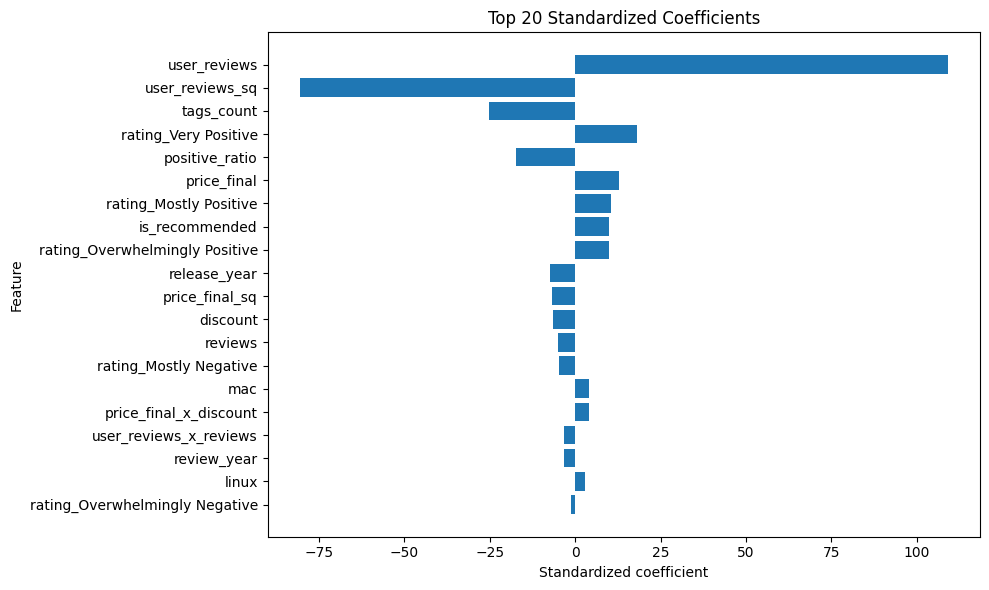


Multicollinearity and VIF
VIF around 1 is low. Above 5 is notable. Above 10 is high.
Polynomial and interaction terms usually raise VIF because they relate to originals.



/Users/chandlercampbell/.venvs/default/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,feature,VIF
0,discount,70.23
1,discount_sq,56.76
2,rating_Overwhelmingly Positive,19.14
3,rating_Very Positive,16.98
4,price_final,12.54
5,user_reviews,11.60
6,price_final_sq,10.63
7,user_reviews_sq,10.33
8,positive_ratio,8.41
9,rating_Mostly Positive,3.94


How I read the VIF table:
- Squares and product terms often have higher VIF. That is normal.
- If a feature has an extreme VIF, I consider dropping a near-duplicate or using Ridge.


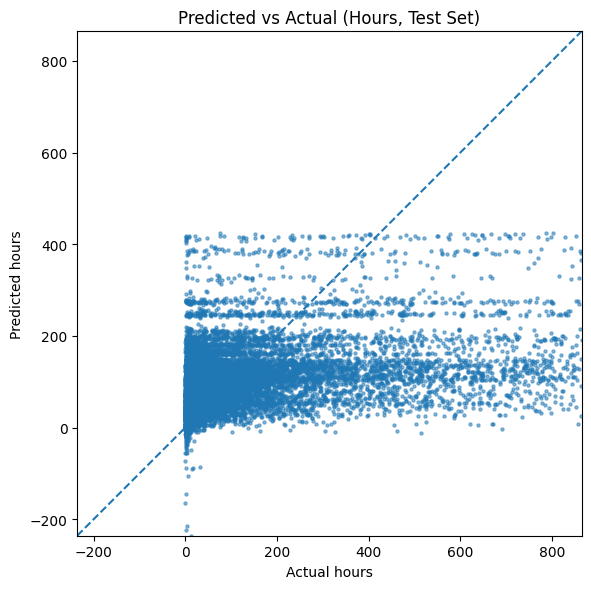


How to read this scatterplot:
- Points on the dashed line are perfect predictions.
- Closer to the line means better fit.

Impact of polynomial terms
I vary price_final and hold other features at typical values.
If the curve bends, the squared term is doing useful work.



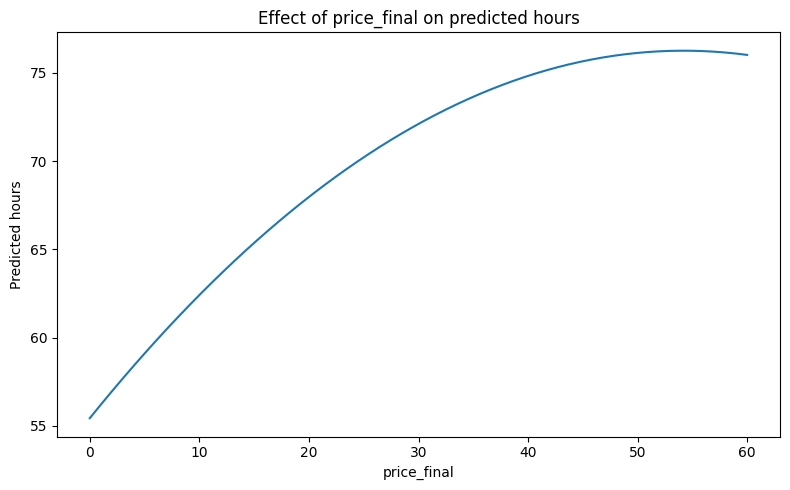


Impact of interaction terms
I vary price_final at two discount levels: low and high.
If the lines have different slopes, the interaction is active.



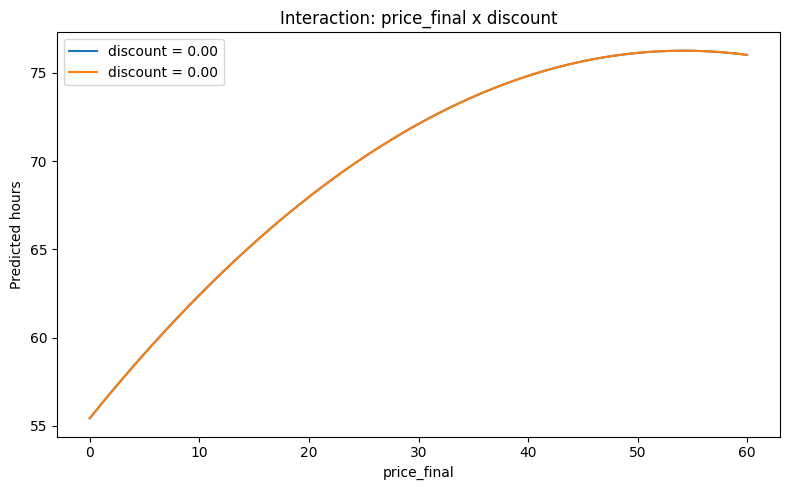

Reading the plot:
- If the two lines are not parallel, the effect of price depends on the discount level.
- That is what the interaction term models.


In [15]:
# =========================================
# Linear Regression on Steam data (no log target)
# Target: "hours"
# Adds: tags_count, outlier trimming, MAE
# Includes: polynomial terms, interaction terms, categorical + continuous features,
# multicollinearity, VIF, clear prints, simple graphs.
# I scale continuous, polynomial, interaction, binary, and dummy features.
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# display prefs
pd.set_option("display.float_format", "{:.6f}".format)
pd.options.display.max_columns = None
pd.options.display.width = 1800
np.set_printoptions(suppress=True)

# -------------------------
# 0) Setup
# -------------------------
TARGET = "hours"
df = steam.copy()

# -------------------------
# 1) Basic cleaning and features
# -------------------------
# parse years from dates
df["release_year"] = pd.to_datetime(df["date_release"], errors="coerce").dt.year
df["review_year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

# booleans to 0/1
for c in ["win", "mac", "linux", "steam_deck", "is_recommended"]:
    if c in df.columns:
        df[c] = df[c].astype(int)

# make tags_count (number of tags) with robust handling
def count_tags(x):
    # list-like
    if isinstance(x, (list, tuple, set)):
        return sum(1 for t in x if str(t).strip() != "")
    if isinstance(x, np.ndarray):
        return int(np.sum([str(t).strip() != "" for t in x]))
    # none / empty / "nan" string
    if x is None:
        return 0
    s = str(x)
    if s.strip() == "" or s.strip().lower() == "nan":
        return 0
    # string separators
    if "|" in s:
        parts = s.split("|")
    else:
        s_clean = s.replace("[", "").replace("]", "").replace("'", "")
        parts = s_clean.split(",")
    return sum(1 for p in parts if str(p).strip() != "")

df["tags_count"] = df["tags"].apply(count_tags)

# cast numeric and fill missing with median
numeric_cols_init = [
    "price_original", "price_final", "discount",
    "user_reviews", "reviews", "positive_ratio",
    "release_year", "review_year", "tags_count", TARGET
]
for c in numeric_cols_init:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
for c in numeric_cols_init:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# trim outliers in hours (keep middle 98%)
df = df[df[TARGET] >= 0]
low_q = df[TARGET].quantile(0.01)
high_q = df[TARGET].quantile(0.99)
df = df[(df[TARGET] >= low_q) & (df[TARGET] <= high_q)]
print(f"I keep hours between the 1st and 99th percentiles: [{low_q:.2f}, {high_q:.2f}]")

# categorical "rating"
if "rating" in df.columns:
    df["rating"] = df["rating"].fillna("Unknown").astype(str)
else:
    df["rating"] = "Unknown"

# one-hot encode rating (drop_first to avoid perfect collinearity)
df = pd.get_dummies(df, columns=["rating"], drop_first=True)

# -------------------------
# 2) Feature sets
# -------------------------
# continuous features
cont = [
    "price_original", "price_final", "discount",
    "user_reviews", "reviews", "positive_ratio",
    "release_year", "review_year", "tags_count"
]

# binary features
bin_cols = [c for c in ["win", "mac", "linux", "steam_deck", "is_recommended"] if c in df.columns]

# rating dummies
rating_cols = [c for c in df.columns if c.startswith("rating_")]

# base features (no poly or interactions yet)
features_base = cont + bin_cols + rating_cols

# keep rows with all needed cols
use_cols = features_base + [TARGET]
dfm = df[use_cols].dropna().copy()

# -------------------------
# 3) Polynomial and interaction terms
# -------------------------
poly_inputs = ["price_final", "discount", "user_reviews"]
for c in poly_inputs:
    dfm[f"{c}_sq"] = dfm[c] ** 2

dfm["price_final_x_discount"] = dfm["price_final"] * dfm["discount"]
dfm["user_reviews_x_reviews"] = dfm["user_reviews"] * dfm["reviews"]

poly_cols = [f"{c}_sq" for c in poly_inputs]
inter_cols = ["price_final_x_discount", "user_reviews_x_reviews"]

features_ext = features_base + poly_cols + inter_cols

# -------------------------
# 4) Train test split
# -------------------------
X = dfm[features_ext]
y = dfm[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# -------------------------
# 5) Standardize continuous, polynomial, interaction, binary, and dummy terms
# -------------------------
cols_to_scale = cont + poly_cols + inter_cols + bin_cols + rating_cols

scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_train_std[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test_std[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("\n=====================================================")
print("Why I standardize")
print("I scale continuous, polynomial, interaction, binary, and dummy features so their coefficients are comparable.")
print("=====================================================\n")

# -------------------------
# 6) Fit regression on standardized features
# -------------------------
model = LinearRegression()
model.fit(X_train_std, y_train)
pred = model.predict(X_test_std)

# metrics
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

metrics = pd.DataFrame({
    "Metric": ["MAE (hours)", "R2"],
    "Value": [mae, r2]
})
display(metrics.style.format({"Value": "{:.4f}"}))

# -------------------------
# 7) Coefficients (standardized predictors)
# -------------------------
coef_df = pd.DataFrame({"feature": X_train_std.columns, "coef_std": model.coef_})
coef_df["abs_coef"] = coef_df["coef_std"].abs()
coef_top = coef_df.sort_values("abs_coef", ascending=False).drop(columns=["abs_coef"]).head(20)

print("\nHow to read the coefficients:")
print("- I standardized all predictor types in cols_to_scale, so larger |coef| means a stronger relationship.")
print("- A positive coefficient increases predicted hours; a negative coefficient decreases them, holding others fixed.")
display(coef_top.style.format({"coef_std": "{:.6f}"}))

plt.figure(figsize=(10, 6))
plt.barh(coef_top["feature"][::-1], coef_top["coef_std"][::-1])
plt.title("Top 20 Standardized Coefficients")
plt.xlabel("Standardized coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# -------------------------
# 8) Multicollinearity and VIF
# -------------------------
print("\n=====================================================")
print("Multicollinearity and VIF")
print("VIF around 1 is low. Above 5 is notable. Above 10 is high.")
print("Polynomial and interaction terms usually raise VIF because they relate to originals.")
print("=====================================================\n")

try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    def compute_vif(X_in, sample_rows=10000):
        Xv = X_in.sample(n=min(sample_rows, len(X_in)), random_state=42).astype(float)
        arr = Xv.values
        names = Xv.columns
        vals = [variance_inflation_factor(arr, i) for i in range(arr.shape[1])]
        out = pd.DataFrame({"feature": names, "VIF": vals})
        return out.sort_values("VIF", ascending=False).reset_index(drop=True)

    vif_table = compute_vif(X_train[features_ext])
    display(vif_table.head(15).style.format({"VIF": "{:.2f}"}))

    print("How I read the VIF table:")
    print("- Squares and product terms often have higher VIF. That is normal.")
    print("- If a feature has an extreme VIF, I consider dropping a near-duplicate or using Ridge.")
except ModuleNotFoundError:
    print("statsmodels is not installed. I skip VIF. Install it with:")
    print("pip install statsmodels")

# -------------------------
# 9) Predicted vs actual
# -------------------------
# sample the scatter for readability
n_points = min(20000, len(y_test))
idx = np.random.RandomState(42).choice(len(y_test), size=n_points, replace=False)

y_a = y_test.iloc[idx]
y_p = pred[idx]

plt.figure(figsize=(6, 6))
plt.scatter(y_a, y_p, s=5, alpha=0.5)
mn = float(min(y_a.min(), y_p.min()))
mx = float(max(y_a.max(), y_p.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlim(mn, mx)
plt.ylim(mn, mx)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Predicted vs Actual (Hours, Test Set)")
plt.xlabel("Actual hours")
plt.ylabel("Predicted hours")
plt.tight_layout()
plt.show()

print("\nHow to read this scatterplot:")
print("- Points on the dashed line are perfect predictions.")
print("- Closer to the line means better fit.")

# -------------------------
# 10) Impact of polynomial terms
# -------------------------
print("\n=====================================================")
print("Impact of polynomial terms")
print("I vary price_final and hold other features at typical values.")
print("If the curve bends, the squared term is doing useful work.")
print("=====================================================\n")

# typical values for other features
typical = {}
for c in cont:
    typical[c] = X_train[c].median()
for c in bin_cols:
    typical[c] = X_train[c].mode().iloc[0] if len(X_train[c].mode()) > 0 else 0
for c in rating_cols:
    typical[c] = 0  # all zeros means the dropped base category

p_grid = np.linspace(
    X_train["price_final"].quantile(0.05),
    X_train["price_final"].quantile(0.95),
    60
)

# frame with base features at typical levels, price_final varies
grid = pd.DataFrame({k: [v]*len(p_grid) for k, v in typical.items()})
grid["price_final"] = p_grid
grid["price_final_sq"] = grid["price_final"] ** 2
grid["discount_sq"] = grid["discount"] ** 2
grid["user_reviews_sq"] = grid["user_reviews"] ** 2
grid["price_final_x_discount"] = grid["price_final"] * grid["discount"]
grid["user_reviews_x_reviews"] = grid["user_reviews"] * grid["reviews"]

# standardize the same columns used in training
grid_std = grid.copy()
grid_std[cols_to_scale] = scaler.transform(grid[cols_to_scale])

curve_hours = model.predict(grid_std[features_ext])

plt.figure(figsize=(8, 5))
plt.plot(p_grid, curve_hours)
plt.title("Effect of price_final on predicted hours")
plt.xlabel("price_final")
plt.ylabel("Predicted hours")
plt.tight_layout()
plt.show()

# -------------------------
# 11) Impact of an interaction term
# -------------------------
print("\n=====================================================")
print("Impact of interaction terms")
print("I vary price_final at two discount levels: low and high.")
print("If the lines have different slopes, the interaction is active.")
print("=====================================================\n")

disc_low = X_train["discount"].quantile(0.1)
disc_high = X_train["discount"].quantile(0.9)

def predict_line_hours(discount_value):
    g = pd.DataFrame({k: [v]*len(p_grid) for k, v in typical.items()})
    g["discount"] = discount_value
    g["price_final"] = p_grid
    g["price_final_sq"] = g["price_final"] ** 2
    g["discount_sq"] = g["discount"] ** 2
    g["user_reviews_sq"] = g["user_reviews"] ** 2
    g["price_final_x_discount"] = g["price_final"] * g["discount"]
    g["user_reviews_x_reviews"] = g["user_reviews"] * g["reviews"]
    gs = g.copy()
    gs[cols_to_scale] = scaler.transform(g[cols_to_scale])
    return model.predict(gs[features_ext])

y_low = predict_line_hours(disc_low)
y_high = predict_line_hours(disc_high)

plt.figure(figsize=(8, 5))
plt.plot(p_grid, y_low, label=f"discount = {disc_low:.2f}")
plt.plot(p_grid, y_high, label=f"discount = {disc_high:.2f}")
plt.title("Interaction: price_final x discount")
plt.xlabel("price_final")
plt.ylabel("Predicted hours")
plt.legend()
plt.tight_layout()
plt.show()

print("Reading the plot:")
print("- If the two lines are not parallel, the effect of price depends on the discount level.")
print("- That is what the interaction term models.")

# Olist

In [16]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113425 entries, 0 to 113424
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_carrier_date   111457 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  113425 non-null  object 
 8   customer_unique_id             113425 non-null  object 
 9   customer_zip_code_prefix       113425 non-null  int64  
 10  customer_city                  113425 non-null  object 
 11  customer_state                 113425 non-null  object 
 12  geolocation_lat               

I keep price between the 1st and 99th percentiles: [9.99, 889.00]

Why I standardize
I scale continuous, polynomial, interaction, binary, and dummy features so their coefficients are comparable.



,Metric,Value
0,MAE (price),55.3277
1,R2,0.3649



How to read the coefficients:
- I standardized all predictor types in cols_to_scale, so larger |coef| means a stronger relationship.
- A positive coefficient increases predicted price, a negative coefficient decreases it, holding others fixed.


,feature,coef_std
0,freight_value,38.229536
1,product_weight_g,33.866410
10,payment_installments_max,26.572850
16,days_purchase_to_customer,24.468664
18,days_carrier_to_customer,-21.887867
145,freight_value_sq,-16.706582
95,product_category_name_english_watches_gifts,16.388594
146,product_weight_g_sq,-15.192219
143,customer_state_SP,-13.071412
64,product_category_name_english_furniture_decor,-12.913530


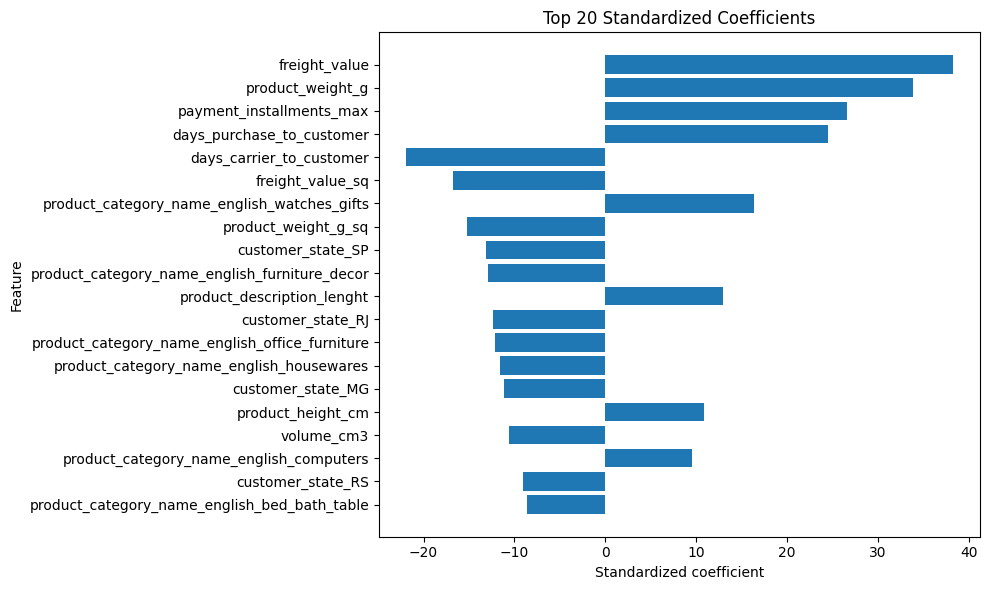


Multicollinearity and VIF
VIF around 1 is low. Above 5 is notable. Above 10 is high.
Squares and product terms usually raise VIF because they relate to originals.



/Users/chandlercampbell/.venvs/default/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,feature,VIF
0,seller_state_SP,1133.66
1,customer_state_SP,800.32
2,seller_state_PR,454.85
3,seller_state_MG,375.20
4,customer_state_RJ,263.28
5,days_purchase_to_customer,256.76
6,seller_state_RJ,230.60
7,customer_state_MG,216.75
8,days_carrier_to_customer,215.78
9,seller_state_SC,214.19


How I read the VIF table:
- Squares and interactions often have higher VIF. That is normal.
- If a feature has an extreme VIF, consider dropping a near duplicate or try Ridge.


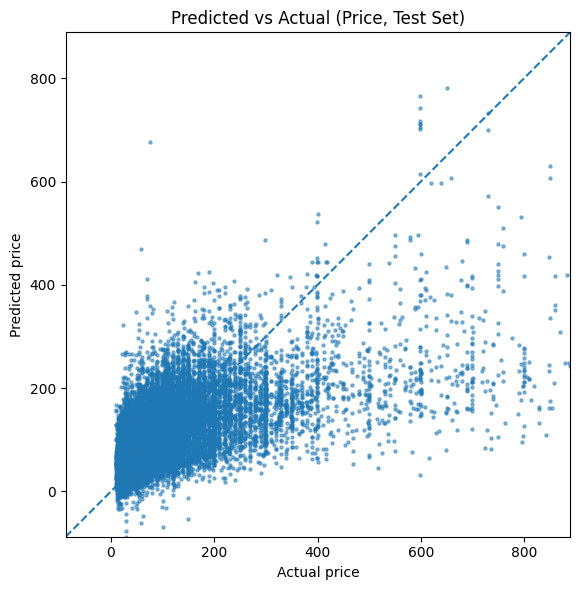


How to read this scatterplot:
- Points on the dashed line are perfect predictions.
- Closer to the line means better fit.

Impact of polynomial terms
I vary freight_value and hold other features at typical values.
If the curve bends, the squared term is doing useful work.



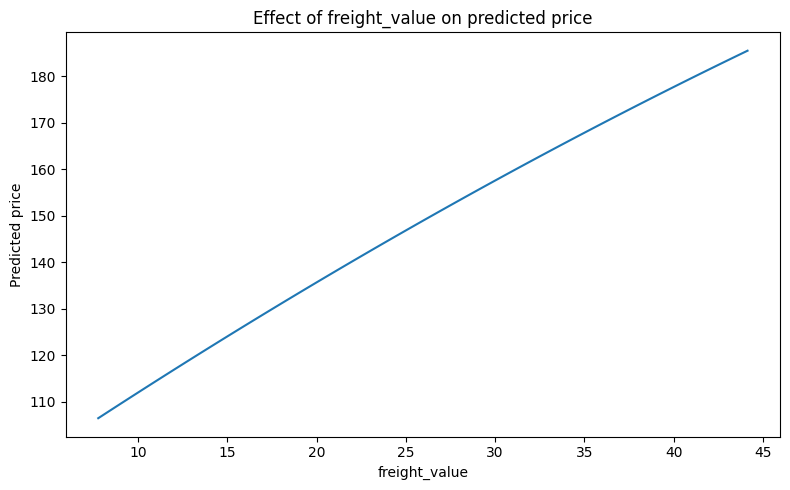


Impact of interaction terms
I vary freight_value at two volume levels: low and high.
If the lines have different slopes, the interaction is active.



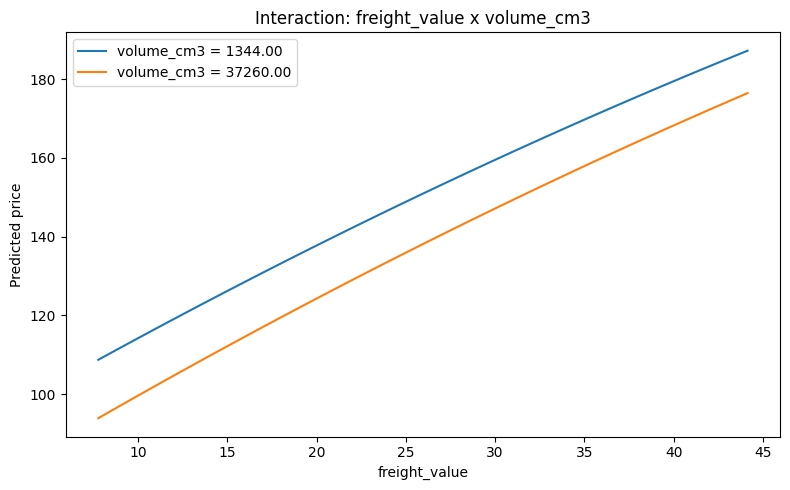

In [18]:
# =========================================
# Linear Regression on Olist data (no log target)
# Target: "price"
# Adds: delivery durations, volume, density, outlier trimming, MAE
# Includes: polynomial terms, interaction terms, categorical + continuous features,
# multicollinearity, VIF, clear prints, simple graphs.
# I scale continuous, polynomial, interaction, binary, and dummy features.
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# display prefs
pd.set_option("display.float_format", "{:.6f}".format)
pd.options.display.max_columns = None
pd.options.display.width = 1800
np.set_printoptions(suppress=True)

# -------------------------
# 0) Setup
# -------------------------
TARGET = "price"
df = olist.copy()

# Helper: make grid/new data match training features
def ensure_train_columns(g, xtrain_cols):
    # add squared terms if base exists
    for col in xtrain_cols:
        if col.endswith("_sq"):
            base = col[:-3]
            if base in g.columns and col not in g.columns:
                g[col] = g[base] ** 2
    # add interactions of the form a_x_b
    for col in xtrain_cols:
        if "_x_" in col and col not in g.columns:
            a, b = col.split("_x_")
            if a in g.columns and b in g.columns:
                g[col] = g[a] * g[b]
    # any remaining train cols not present (e.g., dummies) -> 0
    for col in xtrain_cols:
        if col not in g.columns:
            g[col] = 0
    return g


# -------------------------
# 1) Basic cleaning and features
# -------------------------
# parse timestamps
time_cols = [
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
for c in time_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# delivery durations in days
df["days_purchase_to_approval"] = (df["order_approved_at"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400
df["days_purchase_to_carrier"] = (df["order_delivered_carrier_date"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400
df["days_purchase_to_customer"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400
df["days_purchase_to_estimated"] = (df["order_estimated_delivery_date"] - df["order_purchase_timestamp"]).dt.total_seconds() / 86400
df["days_carrier_to_customer"] = (df["order_delivered_customer_date"] - df["order_delivered_carrier_date"]).dt.total_seconds() / 86400

# month and weekday of purchase
df["purchase_month"] = df["order_purchase_timestamp"].dt.month
df["purchase_dow"] = df["order_purchase_timestamp"].dt.weekday

# geometry based features
if all(c in df.columns for c in ["product_length_cm", "product_height_cm", "product_width_cm"]):
    df["volume_cm3"] = df["product_length_cm"] * df["product_height_cm"] * df["product_width_cm"]
else:
    df["volume_cm3"] = np.nan

if "product_weight_g" in df.columns and "volume_cm3" in df.columns:
    df["density_g_per_cm3"] = df["product_weight_g"] / df["volume_cm3"]
else:
    df["density_g_per_cm3"] = np.nan

# numeric casting and median impute for common numeric fields
numeric_cols_init = [
    "price", "freight_value", "product_weight_g",
    "product_length_cm", "product_height_cm", "product_width_cm",
    "product_photos_qty", "product_name_lenght", "product_description_lenght",
    "payment_installments_max", "payment_count",
    "review_score_mean", "review_count",
    "geolocation_lat", "geolocation_lng", "order_item_id",
    "seller_zip_code_prefix", "volume_cm3", "density_g_per_cm3",
    "days_purchase_to_approval", "days_purchase_to_carrier",
    "days_purchase_to_customer", "days_purchase_to_estimated",
    "days_carrier_to_customer", "purchase_month", "purchase_dow"
]
for c in numeric_cols_init:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
for c in numeric_cols_init:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# trim outliers in price (keep middle 98%)
df = df[df[TARGET] > 0]
low_q = df[TARGET].quantile(0.01)
high_q = df[TARGET].quantile(0.99)
df = df[(df[TARGET] >= low_q) & (df[TARGET] <= high_q)]
print(f"I keep price between the 1st and 99th percentiles: [{low_q:.2f}, {high_q:.2f}]")

# categorical columns
for c in ["product_category_name_english", "seller_state", "customer_state"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown").astype(str)
    else:
        df[c] = "Unknown"

# one-hot encode selected cats (drop_first to avoid perfect collinearity)
df = pd.get_dummies(df, columns=["product_category_name_english", "seller_state", "customer_state"], drop_first=True)

# -------------------------
# 2) Feature sets
# -------------------------
# continuous features
cont = [c for c in [
    "freight_value", "product_weight_g",
    "product_length_cm", "product_height_cm", "product_width_cm",
    "volume_cm3", "density_g_per_cm3",
    "product_photos_qty", "product_name_lenght", "product_description_lenght",
    "payment_installments_max", "payment_count",
    "review_score_mean", "review_count",
    "days_purchase_to_approval", "days_purchase_to_carrier",
    "days_purchase_to_customer", "days_purchase_to_estimated",
    "days_carrier_to_customer", "purchase_month", "purchase_dow",
    "geolocation_lat", "geolocation_lng", "order_item_id", "seller_zip_code_prefix"
] if c in df.columns]

# binary features (none native here, keep hook in case you add any)
bin_cols = []

# dummy columns created above
dummy_prefixes = ["product_category_name_english_", "seller_state_", "customer_state_"]
dummy_cols = [c for c in df.columns if any(c.startswith(p) for p in dummy_prefixes)]

# base features (no poly or interactions yet)
features_base = cont + bin_cols + dummy_cols

# keep rows with all needed cols
use_cols = features_base + [TARGET]
dfm = df[use_cols].dropna().copy()

# -------------------------
# 3) Polynomial and interaction terms
# -------------------------
poly_inputs = [c for c in ["freight_value", "product_weight_g", "volume_cm3"] if c in dfm.columns]
for c in poly_inputs:
    dfm[f"{c}_sq"] = dfm[c] ** 2

# interactions
inter_terms = []
if set(["freight_value", "volume_cm3"]).issubset(dfm.columns):
    dfm["freight_x_volume"] = dfm["freight_value"] * dfm["volume_cm3"]
    inter_terms.append("freight_x_volume")
if set(["freight_value", "payment_installments_max"]).issubset(dfm.columns):
    dfm["freight_x_installments"] = dfm["freight_value"] * dfm["payment_installments_max"]
    inter_terms.append("freight_x_installments")
if set(["product_weight_g", "volume_cm3"]).issubset(dfm.columns):
    dfm["weight_x_volume"] = dfm["product_weight_g"] * dfm["volume_cm3"]
    inter_terms.append("weight_x_volume")

poly_cols = [f"{c}_sq" for c in poly_inputs]
inter_cols = inter_terms

features_ext = features_base + poly_cols + inter_cols

# -------------------------
# 4) Train test split
# -------------------------
X = dfm[features_ext]
y = dfm[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# -------------------------
# 5) Standardize continuous, polynomial, interaction, binary, and dummy terms
# -------------------------
cols_to_scale = cont + poly_cols + inter_cols + bin_cols + dummy_cols
cols_to_scale = [c for c in cols_to_scale if c in X_train.columns]

scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_train_std[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test_std[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("\n=====================================================")
print("Why I standardize")
print("I scale continuous, polynomial, interaction, binary, and dummy features so their coefficients are comparable.")
print("=====================================================\n")

# -------------------------
# 6) Fit regression on standardized features
# -------------------------
model = LinearRegression()
model.fit(X_train_std, y_train)
pred = model.predict(X_test_std)

# metrics
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

metrics = pd.DataFrame({
    "Metric": ["MAE (price)", "R2"],
    "Value": [mae, r2]
})
display(metrics.style.format({"Value": "{:.4f}"}))

# -------------------------
# 7) Coefficients (standardized predictors)
# -------------------------
coef_df = pd.DataFrame({"feature": X_train_std.columns, "coef_std": model.coef_})
coef_df["abs_coef"] = coef_df["coef_std"].abs()
coef_top = coef_df.sort_values("abs_coef", ascending=False).drop(columns=["abs_coef"]).head(20)

print("\nHow to read the coefficients:")
print("- I standardized all predictor types in cols_to_scale, so larger |coef| means a stronger relationship.")
print("- A positive coefficient increases predicted price, a negative coefficient decreases it, holding others fixed.")
display(coef_top.style.format({"coef_std": "{:.6f}"}))

plt.figure(figsize=(10, 6))
plt.barh(coef_top["feature"][::-1], coef_top["coef_std"][::-1])
plt.title("Top 20 Standardized Coefficients")
plt.xlabel("Standardized coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# -------------------------
# 8) Multicollinearity and VIF
# -------------------------
print("\n=====================================================")
print("Multicollinearity and VIF")
print("VIF around 1 is low. Above 5 is notable. Above 10 is high.")
print("Squares and product terms usually raise VIF because they relate to originals.")
print("=====================================================\n")

try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    def compute_vif(X_in, sample_rows=10000):
        Xv = X_in.sample(n=min(sample_rows, len(X_in)), random_state=42).astype(float)
        arr = Xv.values
        names = Xv.columns
        vals = [variance_inflation_factor(arr, i) for i in range(arr.shape[1])]
        out = pd.DataFrame({"feature": names, "VIF": vals})
        return out.sort_values("VIF", ascending=False).reset_index(drop=True)

    vif_table = compute_vif(X_train[features_ext])
    display(vif_table.head(15).style.format({"VIF": "{:.2f}"}))

    print("How I read the VIF table:")
    print("- Squares and interactions often have higher VIF. That is normal.")
    print("- If a feature has an extreme VIF, consider dropping a near duplicate or try Ridge.")
except ModuleNotFoundError:
    print("statsmodels is not installed. I skip VIF. Install it with:")
    print("pip install statsmodels")

# -------------------------
# 9) Predicted vs actual
# -------------------------
# sample the scatter for readability
n_points = min(20000, len(y_test))
rng = np.random.RandomState(42)
idx = rng.choice(len(y_test), size=n_points, replace=False)

y_a = y_test.iloc[idx]
y_p = pred[idx]

plt.figure(figsize=(6, 6))
plt.scatter(y_a, y_p, s=5, alpha=0.5)
mn = float(min(y_a.min(), y_p.min()))
mx = float(max(y_a.max(), y_p.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlim(mn, mx)
plt.ylim(mn, mx)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Predicted vs Actual (Price, Test Set)")
plt.xlabel("Actual price")
plt.ylabel("Predicted price")
plt.tight_layout()
plt.show()

print("\nHow to read this scatterplot:")
print("- Points on the dashed line are perfect predictions.")
print("- Closer to the line means better fit.")

# -------------------------
# 10) Impact of a key polynomial term
# -------------------------
print("\n=====================================================")
print("Impact of polynomial terms")
print("I vary freight_value and hold other features at typical values.")
print("If the curve bends, the squared term is doing useful work.")
print("=====================================================\n")

# typical values for other features
typical = {}
for c in cont:
    if c in X_train.columns:
        typical[c] = X_train[c].median()
for c in bin_cols:
    if c in X_train.columns and len(X_train[c].mode()) > 0:
        typical[c] = X_train[c].mode().iloc[0]
for c in dummy_cols:
    typical[c] = 0  # all zeros means the dropped base category

# grid over freight_value
low_f = X_train["freight_value"].quantile(0.05)
high_f = X_train["freight_value"].quantile(0.95)
f_grid = np.linspace(low_f, high_f, 60)

grid = pd.DataFrame({k: [v]*len(f_grid) for k, v in typical.items()})
grid["freight_value"] = f_grid
# make sure needed columns exist
if "freight_value_sq" in poly_cols:
    grid["freight_value_sq"] = grid["freight_value"] ** 2
if "volume_cm3" in grid.columns and "freight_x_volume" in inter_cols:
    grid["freight_x_volume"] = grid["freight_value"] * grid["volume_cm3"]
if "payment_installments_max" in grid.columns and "freight_x_installments" in inter_cols:
    grid["freight_x_installments"] = grid["freight_value"] * grid["payment_installments_max"]

# ensure grid has every feature used in training
grid = ensure_train_columns(grid, X_train.columns)

# standardize with the same columns as training
grid_std = grid.copy()
grid_std[cols_to_scale] = scaler.transform(grid[cols_to_scale])
curve_price = model.predict(grid_std[features_ext])

# standardize the same columns used in training
grid_std = grid.copy()
grid_std[cols_to_scale] = scaler.transform(grid[cols_to_scale])

curve_price = model.predict(grid_std[features_ext])

plt.figure(figsize=(8, 5))
plt.plot(f_grid, curve_price)
plt.title("Effect of freight_value on predicted price")
plt.xlabel("freight_value")
plt.ylabel("Predicted price")
plt.tight_layout()
plt.show()

# -------------------------
# 11) Impact of an interaction term
# -------------------------
print("\n=====================================================")
print("Impact of interaction terms")
print("I vary freight_value at two volume levels: low and high.")
print("If the lines have different slopes, the interaction is active.")
print("=====================================================\n")

if "volume_cm3" in X_train.columns:
    vol_low = X_train["volume_cm3"].quantile(0.1)
    vol_high = X_train["volume_cm3"].quantile(0.9)

    def predict_line_price(volume_value):
        g = pd.DataFrame({k: [v]*len(f_grid) for k, v in typical.items()})
        g["volume_cm3"] = volume_value
        g["freight_value"] = f_grid
        if "freight_value_sq" in poly_cols:
            g["freight_value_sq"] = g["freight_value"] ** 2
        if "freight_x_volume" in inter_cols:
            g["freight_x_volume"] = g["freight_value"] * g["volume_cm3"]
        if "freight_x_installments" in inter_cols and "payment_installments_max" in g.columns:
            g["freight_x_installments"] = g["freight_value"] * g["payment_installments_max"]
        g = ensure_train_columns(g, X_train.columns)
        gs = g.copy()
        gs[cols_to_scale] = scaler.transform(g[cols_to_scale])
        return model.predict(gs[features_ext])

    y_low = predict_line_price(vol_low)
    y_high = predict_line_price(vol_high)

    plt.figure(figsize=(8, 5))
    plt.plot(f_grid, y_low, label=f"volume_cm3 = {vol_low:.2f}")
    plt.plot(f_grid, y_high, label=f"volume_cm3 = {vol_high:.2f}")
    plt.title("Interaction: freight_value x volume_cm3")
    plt.xlabel("freight_value")
    plt.ylabel("Predicted price")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("volume_cm3 not available. I skip the interaction plot.")


# Video Game Sales

In [19]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55792 entries, 0 to 55791
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rank            55792 non-null  int64  
 1   Name            55792 non-null  object 
 2   basename        55792 non-null  object 
 3   Genre           55792 non-null  object 
 4   ESRB_Rating     23623 non-null  object 
 5   Platform        55792 non-null  object 
 6   Publisher       55792 non-null  object 
 7   Developer       55775 non-null  object 
 8   VGChartz_Score  0 non-null      float64
 9   Critic_Score    6536 non-null   float64
 10  User_Score      335 non-null    float64
 11  Total_Shipped   1827 non-null   float64
 12  Global_Sales    19415 non-null  float64
 13  NA_Sales        12964 non-null  float64
 14  PAL_Sales       13189 non-null  float64
 15  JP_Sales        7043 non-null   float64
 16  Other_Sales     15522 non-null  float64
 17  Year            54813 non-null 

I keep Global_Sales_filled between the 1st and 99th percentiles: [0.01, 3.95]

Why I standardize
I scale continuous, polynomial, interaction, binary, and dummy features so their coefficients are comparable.



,Metric,Value
0,"MAE (Global_Sales, millions)",0.2692
1,R2,0.2540



How to read the coefficients:
- I standardized all predictor types in cols_to_scale, so larger |coef| means a stronger relationship.
- A positive coefficient increases predicted sales, a negative coefficient decreases them, holding others fixed.


,feature,coef_std
1,Critic_Score,-5.136368
129,Year_x_Critic_Score,4.240890
127,Year_sq,-1.865717
0,Year,1.649433
128,Critic_Score_sq,0.550388
130,Critic_x_User,0.442960
45,Platform_PC,-0.098773
117,Developer_top_Other,0.098653
32,Platform_DS,-0.089922
64,Platform_XB,-0.081822


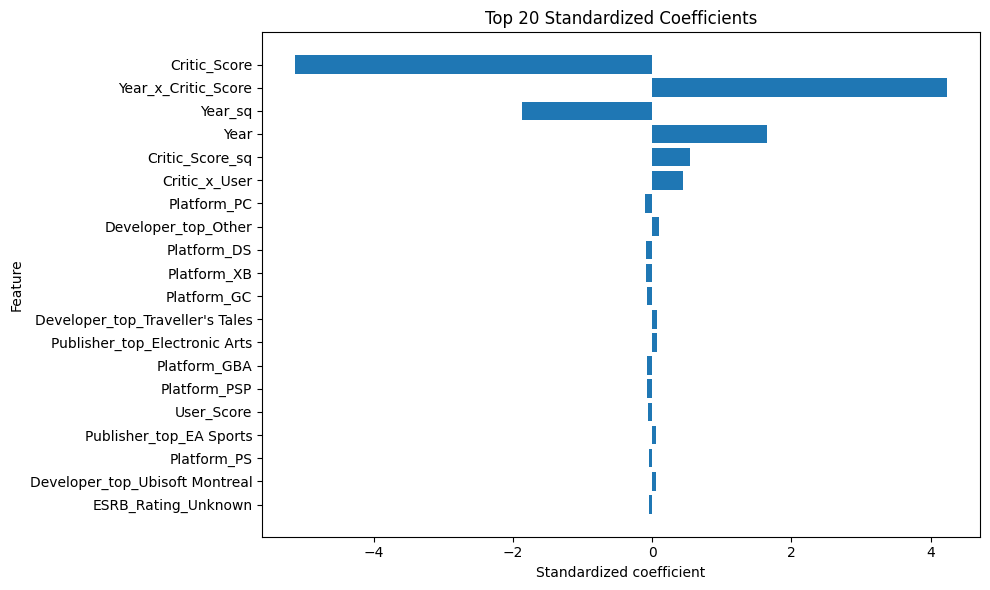


Multicollinearity and VIF
VIF around 1 is low. Above 5 is notable. Above 10 is high.
Squares and product terms usually raise VIF because they relate to originals.



/Users/chandlercampbell/.venvs/default/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,feature,VIF
0,Year,24662418.89
1,Year_sq,23639513.57
2,Critic_Score,181097.59
3,Year_x_Critic_Score,177991.40
4,Critic_x_User,2432.81
5,User_Score,53.89
6,Platform_DS,42.71
7,Platform_PS2,39.22
8,Developer_top_Other,39.04
9,Publisher_top_Other,38.41


How I read the VIF table:
- Squares and interactions often have higher VIF. That is normal.
- If a feature has an extreme VIF, consider dropping a near duplicate or try Ridge.


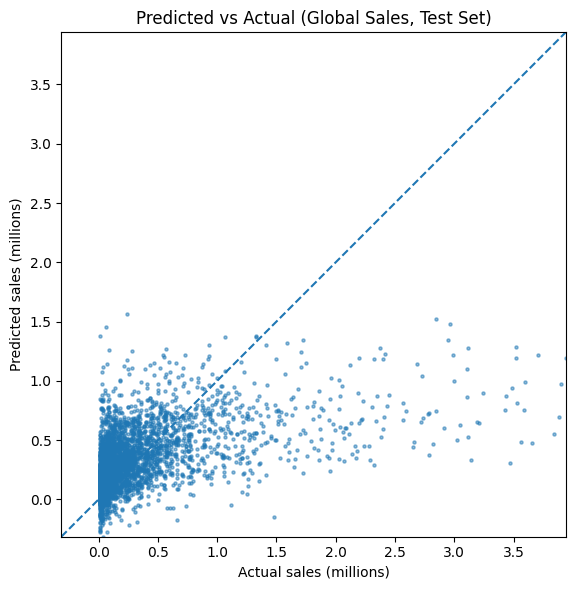


How to read this scatterplot:
- Points on the dashed line are perfect predictions.
- Closer to the line means better fit.

Impact of polynomial terms
I vary Year and hold other features at typical values.
If the curve bends, the squared term is doing useful work.



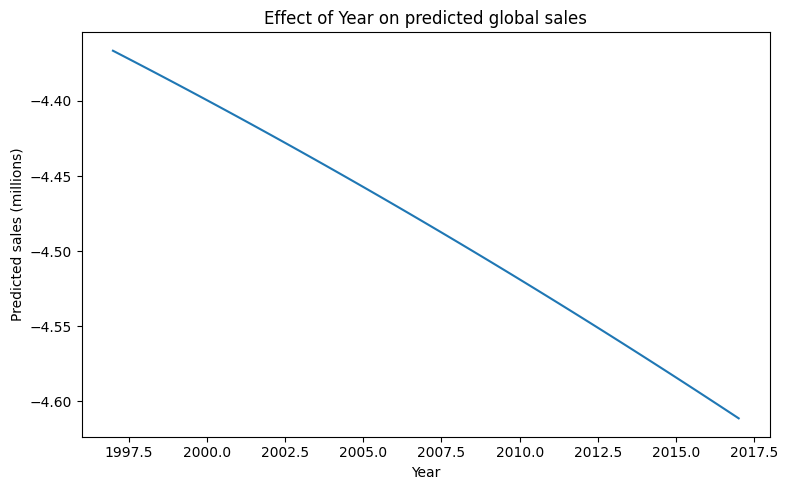


Impact of interaction terms
I vary Year at two platforms: the two most common platforms in the train set.
If the lines have different slopes, the interaction with platform is active through dummies.

Not enough platform variety. I skip the interaction plot.


In [20]:
# =========================================
# Linear Regression on Video Game Sales (no log target)
# Target: "Global_Sales_filled" (millions)
# Includes: polynomial terms, interaction terms, categorical + continuous features,
# multicollinearity, VIF, clear prints, simple graphs.
# I scale continuous, polynomial, interaction, binary, and dummy features.
# =========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# display prefs
pd.set_option("display.float_format", "{:.6f}".format)
pd.options.display.max_columns = None
pd.options.display.width = 1800
np.set_printoptions(suppress=True)

# -------------------------
# 0) Setup
# -------------------------
TARGET = "Global_Sales_filled"
df = sales.copy()

# Helper: keep only top-K categories, others go to "Other"
def keep_top_k(series, k=30):
    vc = series.value_counts(dropna=False)
    tops = set(vc.head(k).index.astype(str))
    s = series.fillna("Unknown").astype(str)
    return s.where(s.isin(tops), other="Other")

# Helper: make grid/new data match training features
def ensure_train_columns(g, xtrain_cols):
    # add squared terms if base exists
    for col in xtrain_cols:
        if col.endswith("_sq"):
            base = col[:-3]
            if base in g.columns and col not in g.columns:
                g[col] = g[base] ** 2
    # add interactions of the form a_x_b
    for col in xtrain_cols:
        if "_x_" in col and col not in g.columns:
            a, b = col.split("_x_")
            if a in g.columns and b in g.columns:
                g[col] = g[a] * g[b]
    # any remaining train cols not present (e.g., dummies) -> 0
    for col in xtrain_cols:
        if col not in g.columns:
            g[col] = 0
    return g

# -------------------------
# 1) Target construction and basic cleaning
# -------------------------
# numeric casting
num_init = ["Global_Sales", "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales",
            "Year", "Critic_Score", "User_Score", "Vgchartzscore"]
for c in num_init:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# backfill Global_Sales using regional sum
region_cols = [c for c in ["NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"] if c in df.columns]
df["Global_Sales_filled"] = df["Global_Sales"]
if len(region_cols) > 0:
    df["regional_sum"] = df[region_cols].sum(axis=1, min_count=1)
    df["Global_Sales_filled"] = df["Global_Sales_filled"].fillna(df["regional_sum"])

# keep positive sales only
df = df[df["Global_Sales_filled"] > 0]

# trim outliers in target (keep middle 98%)
low_q = df["Global_Sales_filled"].quantile(0.01)
high_q = df["Global_Sales_filled"].quantile(0.99)
df = df[(df["Global_Sales_filled"] >= low_q) & (df["Global_Sales_filled"] <= high_q)]
print(f"I keep Global_Sales_filled between the 1st and 99th percentiles: [{low_q:.2f}, {high_q:.2f}]")

# -------------------------
# 2) Feature engineering
# -------------------------
# avoid leakage: drop region sales, Total_Shipped, and Rank from features
# categorical cleanup
for c in ["Genre", "ESRB_Rating", "Platform", "Publisher", "Developer"]:
    if c in df.columns:
        df[c] = df[c].fillna("Unknown").astype(str)
    else:
        df[c] = "Unknown"

# cap high-card publishers and developers
df["Publisher_top"] = keep_top_k(df["Publisher"], k=30)
df["Developer_top"] = keep_top_k(df["Developer"], k=30)

# numeric impute
num_use_init = ["Year", "Critic_Score", "User_Score", "Vgchartzscore"]
for c in num_use_init:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# one-hot encode selected categories (drop_first to avoid perfect collinearity)
cat_cols_to_dum = ["Genre", "ESRB_Rating", "Platform", "Publisher_top", "Developer_top"]
df = pd.get_dummies(df, columns=cat_cols_to_dum, drop_first=True)

# -------------------------
# 3) Feature sets
# -------------------------
# continuous features
cont = [c for c in ["Year", "Critic_Score", "User_Score", "Vgchartzscore"] if c in df.columns]

# binary features (none native here)
bin_cols = []

# dummy columns
dummy_prefixes = ["Genre_", "ESRB_Rating_", "Platform_", "Publisher_top_", "Developer_top_"]
dummy_cols = [c for c in df.columns if any(c.startswith(p) for p in dummy_prefixes)]

# base features (no poly or interactions yet)
features_base = cont + bin_cols + dummy_cols

# keep rows with all needed cols
use_cols = features_base + [TARGET]
dfm = df[use_cols].dropna().copy()

# -------------------------
# 4) Polynomial and interaction terms
# -------------------------
poly_inputs = [c for c in ["Year", "Critic_Score"] if c in dfm.columns]
for c in poly_inputs:
    dfm[f"{c}_sq"] = dfm[c] ** 2

inter_terms = []
if set(["Year", "Critic_Score"]).issubset(dfm.columns):
    dfm["Year_x_Critic_Score"] = dfm["Year"] * dfm["Critic_Score"]
    inter_terms.append("Year_x_Critic_Score")
if set(["Critic_Score", "User_Score"]).issubset(dfm.columns):
    dfm["Critic_x_User"] = dfm["Critic_Score"] * dfm["User_Score"]
    inter_terms.append("Critic_x_User")

poly_cols = [f"{c}_sq" for c in poly_inputs]
inter_cols = inter_terms

features_ext = features_base + poly_cols + inter_cols

# -------------------------
# 5) Train test split
# -------------------------
X = dfm[features_ext]
y = dfm[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# -------------------------
# 6) Standardize continuous, polynomial, interaction, binary, and dummy terms
# -------------------------
cols_to_scale = cont + poly_cols + inter_cols + bin_cols + dummy_cols
cols_to_scale = [c for c in cols_to_scale if c in X_train.columns]

scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

X_train_std = X_train.copy()
X_test_std = X_test.copy()
X_train_std[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test_std[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("\n=====================================================")
print("Why I standardize")
print("I scale continuous, polynomial, interaction, binary, and dummy features so their coefficients are comparable.")
print("=====================================================\n")

# -------------------------
# 7) Fit regression on standardized features
# -------------------------
model = LinearRegression()
model.fit(X_train_std, y_train)
pred = model.predict(X_test_std)

# metrics
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

metrics = pd.DataFrame({
    "Metric": ["MAE (Global_Sales, millions)", "R2"],
    "Value": [mae, r2]
})
display(metrics.style.format({"Value": "{:.4f}"}))

# -------------------------
# 8) Coefficients (standardized predictors)
# -------------------------
coef_df = pd.DataFrame({"feature": X_train_std.columns, "coef_std": model.coef_})
coef_df["abs_coef"] = coef_df["coef_std"].abs()
coef_top = coef_df.sort_values("abs_coef", ascending=False).drop(columns=["abs_coef"]).head(20)

print("\nHow to read the coefficients:")
print("- I standardized all predictor types in cols_to_scale, so larger |coef| means a stronger relationship.")
print("- A positive coefficient increases predicted sales, a negative coefficient decreases them, holding others fixed.")
display(coef_top.style.format({"coef_std": "{:.6f}"}))

plt.figure(figsize=(10, 6))
plt.barh(coef_top["feature"][::-1], coef_top["coef_std"][::-1])
plt.title("Top 20 Standardized Coefficients")
plt.xlabel("Standardized coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# -------------------------
# 9) Multicollinearity and VIF
# -------------------------
print("\n=====================================================")
print("Multicollinearity and VIF")
print("VIF around 1 is low. Above 5 is notable. Above 10 is high.")
print("Squares and product terms usually raise VIF because they relate to originals.")
print("=====================================================\n")

try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    def compute_vif(X_in, sample_rows=10000):
        Xv = X_in.sample(n=min(sample_rows, len(X_in)), random_state=42).astype(float)
        arr = Xv.values
        names = Xv.columns
        vals = [variance_inflation_factor(arr, i) for i in range(arr.shape[1])]
        out = pd.DataFrame({"feature": names, "VIF": vals})
        return out.sort_values("VIF", ascending=False).reset_index(drop=True)

    vif_table = compute_vif(X_train[features_ext])
    display(vif_table.head(15).style.format({"VIF": "{:.2f}"}))

    print("How I read the VIF table:")
    print("- Squares and interactions often have higher VIF. That is normal.")
    print("- If a feature has an extreme VIF, consider dropping a near duplicate or try Ridge.")
except ModuleNotFoundError:
    print("statsmodels is not installed. I skip VIF. Install it with:")
    print("pip install statsmodels")

# -------------------------
# 10) Predicted vs actual
# -------------------------
# sample the scatter for readability
n_points = min(20000, len(y_test))
rng = np.random.RandomState(42)
idx = rng.choice(len(y_test), size=n_points, replace=False)

y_a = y_test.iloc[idx]
y_p = pred[idx]

plt.figure(figsize=(6, 6))
plt.scatter(y_a, y_p, s=5, alpha=0.5)
mn = float(min(y_a.min(), y_p.min()))
mx = float(max(y_a.max(), y_p.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlim(mn, mx)
plt.ylim(mn, mx)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Predicted vs Actual (Global Sales, Test Set)")
plt.xlabel("Actual sales (millions)")
plt.ylabel("Predicted sales (millions)")
plt.tight_layout()
plt.show()

print("\nHow to read this scatterplot:")
print("- Points on the dashed line are perfect predictions.")
print("- Closer to the line means better fit.")

# -------------------------
# 11) Impact of a key polynomial term
# -------------------------
print("\n=====================================================")
print("Impact of polynomial terms")
print("I vary Year and hold other features at typical values.")
print("If the curve bends, the squared term is doing useful work.")
print("=====================================================\n")

# typical values for other features
typical = {}
for c in cont:
    if c in X_train.columns:
        typical[c] = X_train[c].median()
for c in bin_cols:
    if c in X_train.columns and len(X_train[c].mode()) > 0:
        typical[c] = X_train[c].mode().iloc[0]
for c in dummy_cols:
    typical[c] = 0  # all zeros means the dropped base category

# grid over Year
low_y = X_train["Year"].quantile(0.05) if "Year" in X_train.columns else 2000.0
high_y = X_train["Year"].quantile(0.95) if "Year" in X_train.columns else 2020.0
y_grid = np.linspace(low_y, high_y, 60)

grid = pd.DataFrame({k: [v]*len(y_grid) for k, v in typical.items()})
if "Year" in X_train.columns:
    grid["Year"] = y_grid
if "Year_sq" in poly_cols:
    grid["Year_sq"] = grid["Year"] ** 2
if "Year_x_Critic_Score" in inter_cols and "Critic_Score" in grid.columns:
    grid["Year_x_Critic_Score"] = grid["Year"] * grid["Critic_Score"]

# ensure grid has every feature used in training
grid = ensure_train_columns(grid, X_train.columns)

# standardize and predict
grid_std = grid.copy()
grid_std[cols_to_scale] = scaler.transform(grid[cols_to_scale])
curve_sales = model.predict(grid_std[features_ext])

plt.figure(figsize=(8, 5))
plt.plot(y_grid, curve_sales)
plt.title("Effect of Year on predicted global sales")
plt.xlabel("Year")
plt.ylabel("Predicted sales (millions)")
plt.tight_layout()
plt.show()

# -------------------------
# 12) Impact of an interaction term
# -------------------------
print("\n=====================================================")
print("Impact of interaction terms")
print("I vary Year at two platforms: the two most common platforms in the train set.")
print("If the lines have different slopes, the interaction with platform is active through dummies.")
print("=====================================================\n")

# choose two common platforms
top_platforms = df.loc[X_train.index, "Platform"].value_counts().head(2).index.tolist() if "Platform" in df.columns else []
plat_dummies = [c for c in X_train.columns if c.startswith("Platform_")]

def predict_line_platform(platform_name):
    g = pd.DataFrame({k: [v]*len(y_grid) for k, v in typical.items()})
    if "Year" in X_train.columns:
        g["Year"] = y_grid
        if "Year_sq" in poly_cols:
            g["Year_sq"] = g["Year"] ** 2
    # zero all platform dummies, then set one if it exists
    for d in plat_dummies:
        g[d] = 0
    col_name = f"Platform_{platform_name}"
    if col_name in g.columns:
        g[col_name] = 1
    g = ensure_train_columns(g, X_train.columns)
    gs = g.copy()
    gs[cols_to_scale] = scaler.transform(g[cols_to_scale])
    return model.predict(gs[features_ext])

if len(top_platforms) >= 2:
    y_p1 = predict_line_platform(top_platforms[0])
    y_p2 = predict_line_platform(top_platforms[1])

    plt.figure(figsize=(8, 5))
    plt.plot(y_grid, y_p1, label=f"Platform = {top_platforms[0]}")
    plt.plot(y_grid, y_p2, label=f"Platform = {top_platforms[1]}")
    plt.title("Year effect by platform")
    plt.xlabel("Year")
    plt.ylabel("Predicted sales (millions)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough platform variety. I skip the interaction plot.")
